# Table of contents
1. [Introduction](#introduction)
2. [Project Description](#paragraph1)
3. [Description of the data](#paragraph2)

    
## Introduction <a name="introduction"></a>
Time Series Project for Yandex Practicum Course
    
## Project Description <a name="paragraph1"></a>

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.
The RMSE metric on the test set should not be more than 48.


## Description of the data <a name="paragraph2"></a>

    The number of orders is in the num_orders column.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, TimeSeriesSplit

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install -U scikit-learn
!pip install -U seaborn
!pip install xgboost
!pip install lightgbm
!pip install catboost

### Data preparation & analysis

In [2]:
# Load data

try:
    df = pd.read_csv('taxi.csv')
    
except:
    df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
    
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
df.index.is_monotonic

True

data in chronological order

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
# resample data per 1h

df = df.resample('1h').sum()

#### Augmented Dickey-Fuller


**Null Hypothesis (H0):** If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1):** The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

**p-value > 0.05:** Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= 0.05:** Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

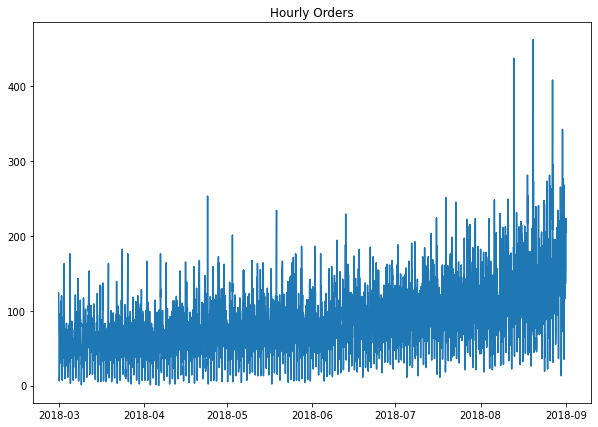

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(figsize=(10,7))
plt.plot(df);
plt.title('Hourly Orders');

In [11]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

X = df.loc[:, 'num_orders'].values
result = adfuller(X)
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -3.068924289027937
n_lags: 0.028940051402614374
p-value: 0.028940051402614374
Critial Values:
   1%, -3.431842162413052
Critial Values:
   5%, -2.8621993540813637
Critial Values:
   10%, -2.567120978470452


Data is stationary, when considering a significance level of 0.05

<AxesSubplot:xlabel='datetime'>

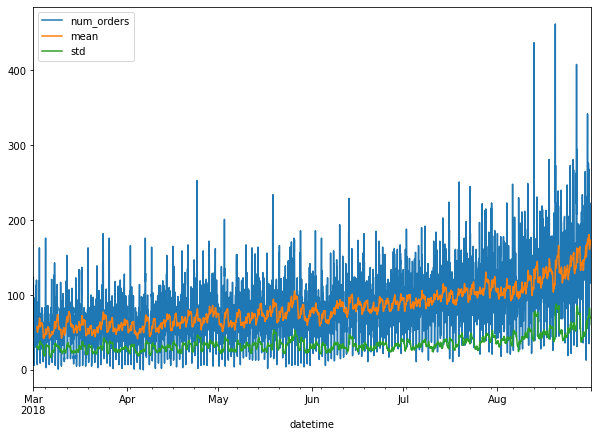

In [12]:
df_hourly = df.copy()

df_hourly['mean'] = df_hourly['num_orders'].rolling(30).mean()
df_hourly['std'] = df_hourly['num_orders'].rolling(30).std()
df_hourly.plot(figsize=(10,7))

In [13]:
def decomp(data):
    
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(12,24))

    plt.subplot(611)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')

    plt.subplot(612)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.subplot(613)
    decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
    plt.title('Monthly Seasonality')
    
    plt.subplot(614)
    decomposed.seasonal['2018-08-15':'2018-08-31'].plot(ax=plt.gca())
    plt.title('Fortnightly Seasonality')
    
    plt.subplot(615)
    decomposed.seasonal['2018-08-29':'2018-08-30'].plot(ax=plt.gca())
    plt.title('Daily Seasonality')

    plt.subplot(616)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    
    plt.tight_layout()

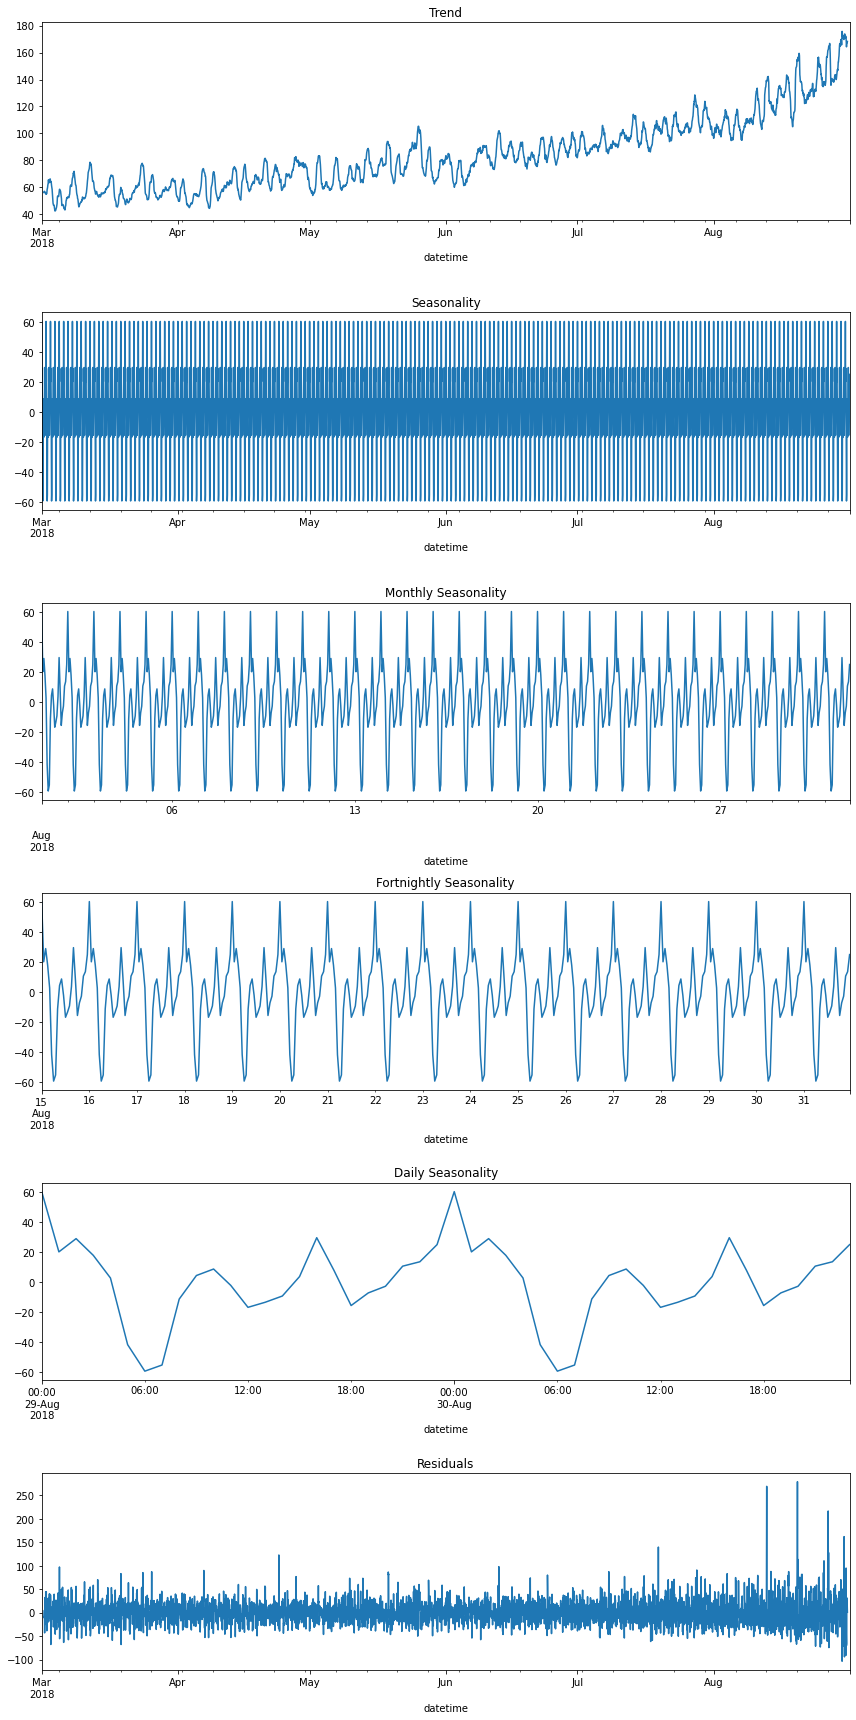

In [14]:
decomp(df)

### Considerations:

1. Data is stationary - (if working with a smaller significance level as per example 0.01 data wouldn't be stationary **would like some input on this** )
2. The trend graph shows a increase in the number of orders from March to September.
3. Seasonality, apparently related to the time of day at which the orders were made, is stationary, the minimum number of orders drops at 06H, the maximum is arround 22H-24H.
4. Noises are practically stationary and grow towards the end of the time period. Perhaps this will negatively affect the results of predictions, since the test sample will include just the last 10% of the dataset.

### Model Training & Testing

In [15]:
def df_features(data, max_lag, rolling_mean_size):
    
    data_temp = data.copy()
    data_temp['dayofweek'] = data_temp.index.dayofweek
    data_temp['hour'] = data_temp.index.hour
    
    for lag in range(1, max_lag + 1):
        data_temp['lag_{}'.format(lag)] = data_temp['num_orders'].shift(lag)

    data_temp['rolling_mean'] = data_temp['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_temp = data_temp.dropna()
    
    return data_temp


In [16]:
df_train = df_features(df, 12, 30)

In [17]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4386.0,84.602599,45.052126,0.000000,54.000000,78.000000,108.000000,462.000000
dayofweek,4386.0,3.004104,1.997143,0.000000,1.000000,3.000000,5.000000,6.000000
hour,4386.0,11.512312,6.919406,0.000000,6.000000,12.000000,18.000000,23.000000
lag_1,4386.0,84.558368,45.029122,0.000000,54.000000,78.000000,108.000000,462.000000
lag_2,4386.0,84.512084,44.991102,0.000000,54.000000,78.000000,107.750000,462.000000
lag_3,4386.0,84.490424,44.978100,0.000000,54.000000,78.000000,107.000000,462.000000
lag_4,4386.0,84.472412,44.966074,0.000000,54.000000,78.000000,107.000000,462.000000
lag_5,4386.0,84.468764,44.962542,0.000000,54.000000,78.000000,107.000000,462.000000
lag_6,4386.0,84.442088,44.924520,0.000000,54.000000,78.000000,107.000000,462.000000
lag_7,4386.0,84.405837,44.881660,0.000000,54.000000,78.000000,107.000000,462.000000


In [18]:
target = "num_orders"
features = set(df_train.columns)-set([target])

X, y = df_train[features], df_train[target]

X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], shuffle=False, test_size=0.1)

In [19]:
print('Training sample size:', X_train.shape)
print('Test sample size:', X_test.shape)

Training sample size: (3947, 15)
Test sample size: (439, 15)


In [20]:
table_results = dict()

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
def analysis_model(model_name, model,features_test, target_test,features_train, target_train, parameters=None):

    print('model name:', model_name)
      
    predicted_test = model.predict(features_test)
    predicted_train = model.predict(features_train)
    
    # MSE Test
    mse_test = mean_squared_error(target_test, predicted_test)
   
    # RMSE Test
    rmse_test = mse_test ** 0.5
    
    # MSE Train
    mse_train = mean_squared_error(target_train, predicted_train)
    
    # RMSE Train
    rmse_train = mse_train ** 0.5
    
    # MAPE 
    mape_test = mean_absolute_percentage_error(target_test, predicted_test)
    mape_train = mean_absolute_percentage_error(target_train, predicted_train)
    
    plotModelResults(model,features_train, features_test,True,False)
    
    print('Parameters:', parameters)
    print('RMSE for training set:', rmse_train)
    print('RMSE for test set:', rmse_test)

    table_results[model_name] = {
        'model': model_name,
        'rmse test':rmse_test,
        'rmse train':rmse_train
    }

In [23]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    # for time-series cross-validation set 5 folds 
    tscv = TimeSeriesSplit(n_splits=5)
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(24, 12))
    plt.plot(prediction, "darkorange", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    #error = mean_absolute_percentage_error(prediction, y_test)
    
    mse = mean_squared_error(prediction, y_test)
    
    # RMSE Train
    error = mse ** 0.5
    
    plt.title("mean_squared_error percentage {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.grid(True);
    


#### Linear regression

In [24]:
%%time

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

Wall time: 10.5 ms


LinearRegression()

model name: Linear Regression
Parameters: None
RMSE for training set: 30.378686916830894
RMSE for test set: 50.64636785264724


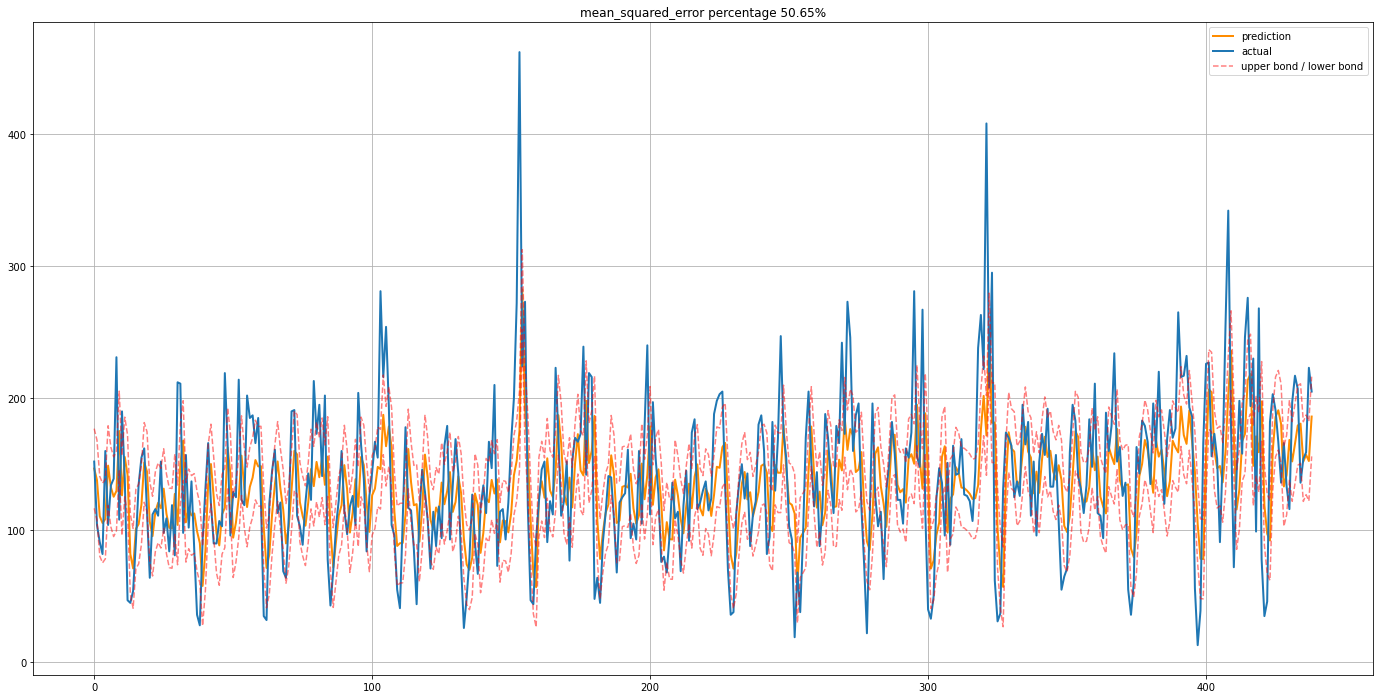

In [25]:
analysis_model('Linear Regression', lr_model, X_test, y_test, X_train, y_train)

#### RandomForestRegressor

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

In [27]:
%%time

RF_model = RandomForestRegressor()

RF_params = {
    'n_estimators': [50,300,50],
    'max_depth':[5,15],
    'max_features' : [1,20, 2]
}

RF_grid = RandomizedSearchCV(estimator = RF_model, param_distributions = RF_params, scoring = 'neg_mean_squared_error', cv = tscv, n_iter = 20, n_jobs= -1)
RF_grid.fit(X_train, y_train)

Wall time: 9.78 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [5, 15],
                                        'max_features': [1, 20, 2],
                                        'n_estimators': [50, 300, 50]},
                   scoring='neg_mean_squared_error')

model name: Random Forest Regressor
Parameters: {'n_estimators': 300, 'max_features': 2, 'max_depth': 15}
RMSE for training set: 11.134455832724793
RMSE for test set: 49.279859539238686


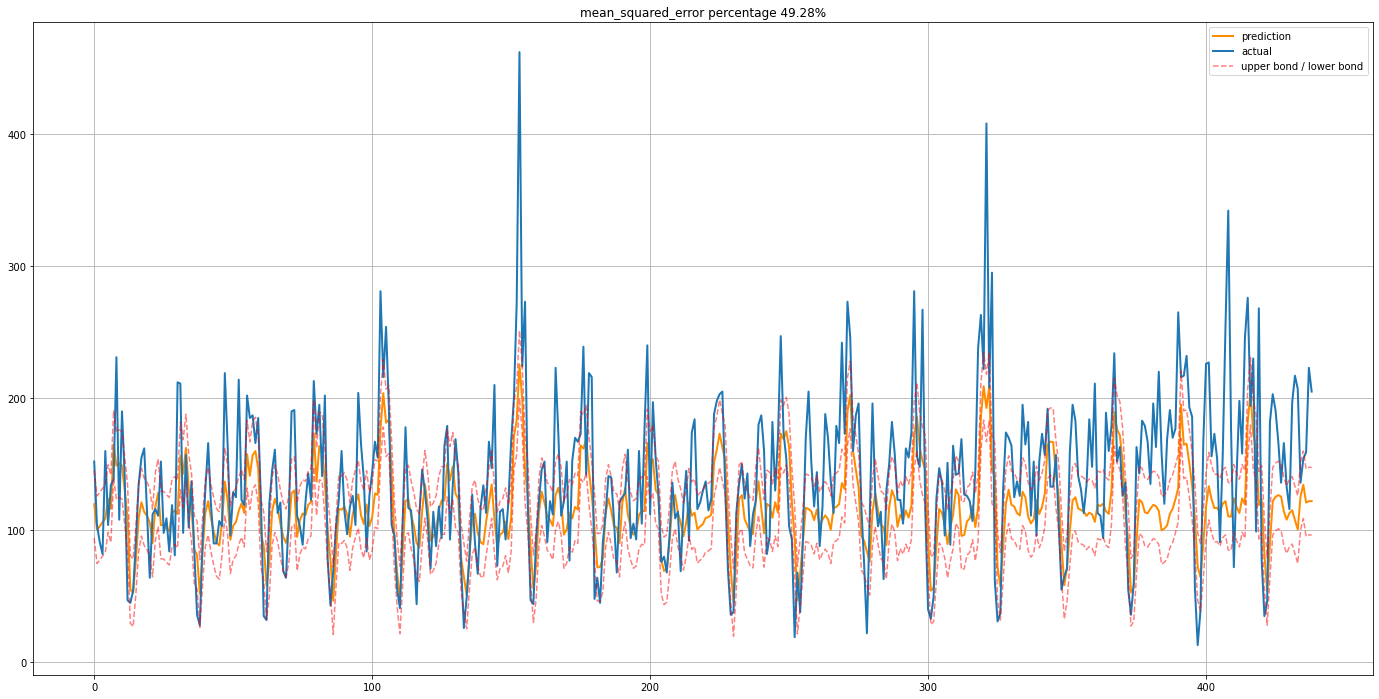

In [28]:
analysis_model('Random Forest Regressor', RF_grid, X_test, y_test, X_train, y_train, RF_grid.best_params_)

#### XGBoost

In [29]:
%%time

xgb_model = XGBRegressor()

xgb_params = {
    "max_depth": range(3, 20,2),
    "min_child_weight": range(1,24,2)
}

xgb_grid = RandomizedSearchCV(estimator = xgb_model, param_distributions = xgb_params, scoring = 'neg_mean_squared_error', n_jobs= -1, cv = tscv)
xgb_grid.fit(X_train, y_train)

Wall time: 16.1 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_w...nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, re

model name: XGBRegressor
Parameters: {'min_child_weight': 23, 'max_depth': 7}
RMSE for training set: 8.999163106006499
RMSE for test set: 42.40750791474617


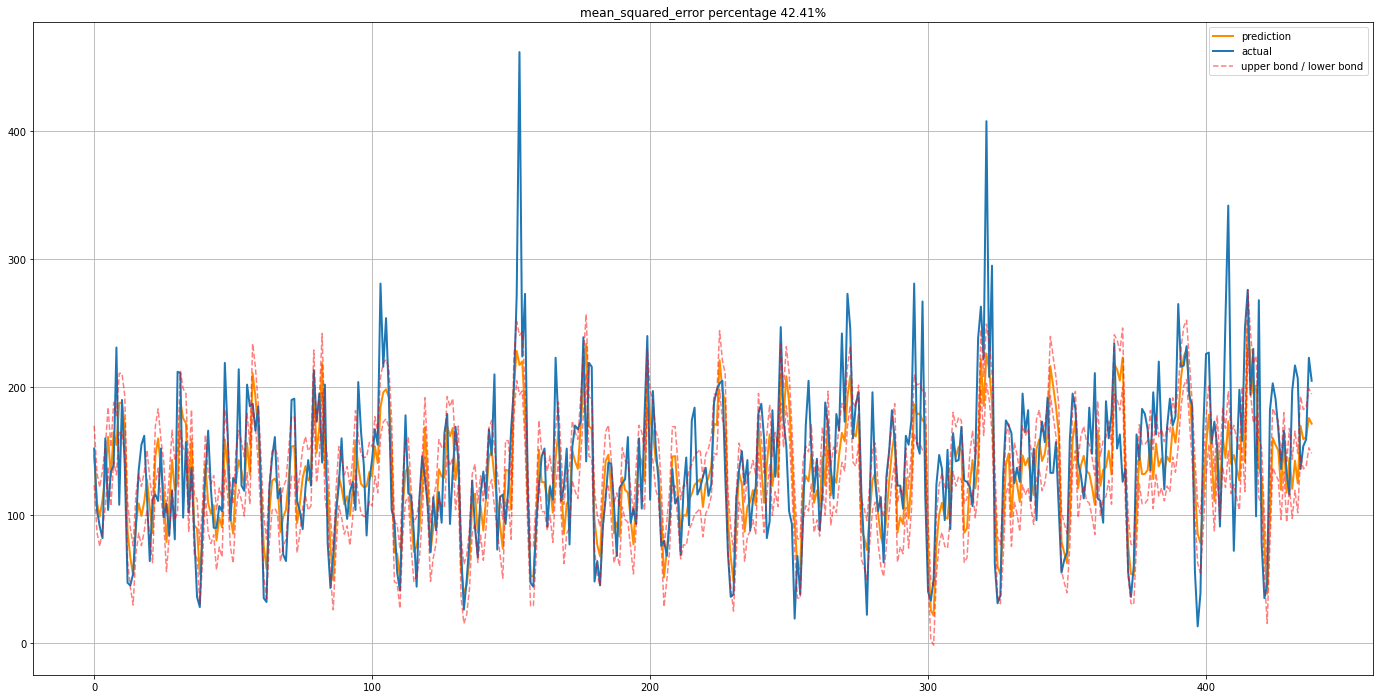

In [30]:
analysis_model('XGBRegressor', xgb_grid, X_test, y_test, X_train, y_train, xgb_grid.best_params_)

#### LightGBM

In [31]:
%%time

gbm_model = LGBMRegressor()

gbm_params = {
    'objective': ['regression','binary'],
    'boosting_type' : ['dart','gbdt','goss'],
    'max_depth': range(1,60,5),
    'num_leaves': [10,200,300]
}

gbm_grid = RandomizedSearchCV(estimator = gbm_model, param_distributions = gbm_params, scoring = 'neg_mean_squared_error', n_jobs= -1, cv = tscv)
gbm_grid.fit(X_train, y_train)

Wall time: 7.86 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'boosting_type': ['dart', 'gbdt',
                                                          'goss'],
                                        'max_depth': range(1, 60, 5),
                                        'num_leaves': [10, 200, 300],
                                        'objective': ['regression', 'binary']},
                   scoring='neg_mean_squared_error')

model name: LightGBM
Parameters: {'objective': 'regression', 'num_leaves': 300, 'max_depth': 51, 'boosting_type': 'gbdt'}
RMSE for training set: 5.7245921660840455
RMSE for test set: 42.93900720955882


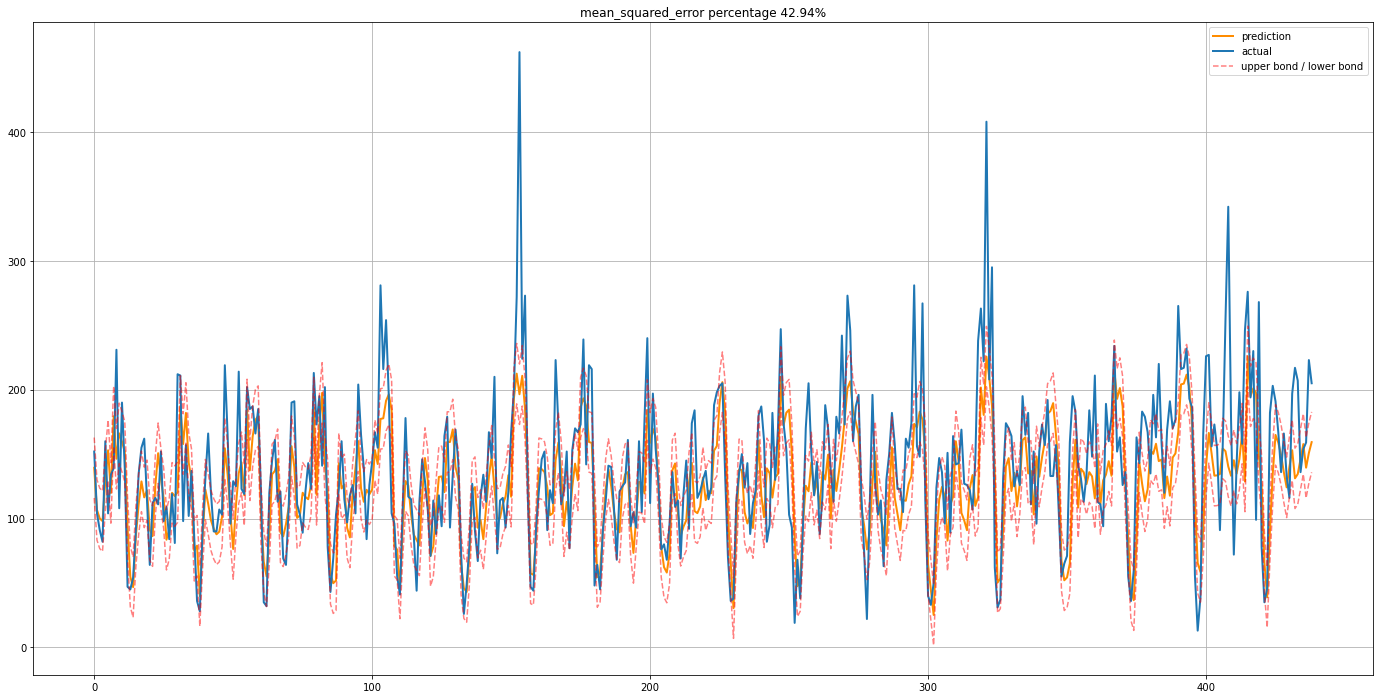

In [32]:
analysis_model('LightGBM', gbm_grid, X_test, y_test, X_train, y_train, gbm_grid.best_params_)

#### CatBoost

In [33]:
%%time

catBoost_model = CatBoostRegressor(loss_function="RMSE", iterations=20)

catBoost_params = {
    'learning_rate': [0.1],
    'depth': [3, 4, 5, 6, 7, 8],
    'l2_leaf_reg': [1, 2, 3]
}

catBoost_grid = RandomizedSearchCV(estimator = catBoost_model, param_distributions = catBoost_params, n_jobs= -1, cv = tscv)
catBoost_grid.fit(X_train, y_train)

0:	learn: 36.9422611	total: 125ms	remaining: 2.37s
1:	learn: 35.2404823	total: 130ms	remaining: 1.17s
2:	learn: 33.9457299	total: 136ms	remaining: 771ms
3:	learn: 32.6167430	total: 142ms	remaining: 566ms
4:	learn: 31.5080689	total: 148ms	remaining: 443ms
5:	learn: 30.5000105	total: 154ms	remaining: 359ms
6:	learn: 29.6938545	total: 160ms	remaining: 297ms
7:	learn: 29.0753293	total: 165ms	remaining: 248ms
8:	learn: 28.3667909	total: 171ms	remaining: 209ms
9:	learn: 27.9976346	total: 177ms	remaining: 177ms
10:	learn: 27.4686141	total: 183ms	remaining: 150ms
11:	learn: 27.0571265	total: 189ms	remaining: 126ms
12:	learn: 26.6042123	total: 195ms	remaining: 105ms
13:	learn: 26.2817062	total: 200ms	remaining: 85.7ms
14:	learn: 25.9172636	total: 206ms	remaining: 68.6ms
15:	learn: 25.6238393	total: 211ms	remaining: 52.8ms
16:	learn: 25.3507658	total: 217ms	remaining: 38.3ms
17:	learn: 25.1802096	total: 222ms	remaining: 24.7ms
18:	learn: 24.9100754	total: 227ms	remaining: 12ms
19:	learn: 24.6475

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000249833DE850>,
                   n_jobs=-1,
                   param_distributions={'depth': [3, 4, 5, 6, 7, 8],
                                        'l2_leaf_reg': [1, 2, 3],
                                        'learning_rate': [0.1]})

model name: CatBoost
0:	learn: 28.2127081	total: 1.12ms	remaining: 21.3ms
1:	learn: 27.4891989	total: 2.33ms	remaining: 21ms
2:	learn: 26.3252127	total: 3.36ms	remaining: 19ms
3:	learn: 25.5244632	total: 4.42ms	remaining: 17.7ms
4:	learn: 24.6017157	total: 5.45ms	remaining: 16.3ms
5:	learn: 23.7073545	total: 6.49ms	remaining: 15.2ms
6:	learn: 23.0559038	total: 7.52ms	remaining: 14ms
7:	learn: 22.4953942	total: 8.57ms	remaining: 12.9ms
8:	learn: 21.8781495	total: 9.66ms	remaining: 11.8ms
9:	learn: 21.5772371	total: 10.7ms	remaining: 10.7ms
10:	learn: 21.2530773	total: 11.8ms	remaining: 9.65ms
11:	learn: 20.8818841	total: 12.8ms	remaining: 8.56ms
12:	learn: 20.6102991	total: 13.9ms	remaining: 7.51ms
13:	learn: 20.3366784	total: 14.9ms	remaining: 6.4ms
14:	learn: 19.9811363	total: 16ms	remaining: 5.33ms
15:	learn: 19.7811405	total: 17ms	remaining: 4.26ms
16:	learn: 19.4801252	total: 18.1ms	remaining: 3.19ms
17:	learn: 19.3115245	total: 19.1ms	remaining: 2.12ms
18:	learn: 19.1271976	total:

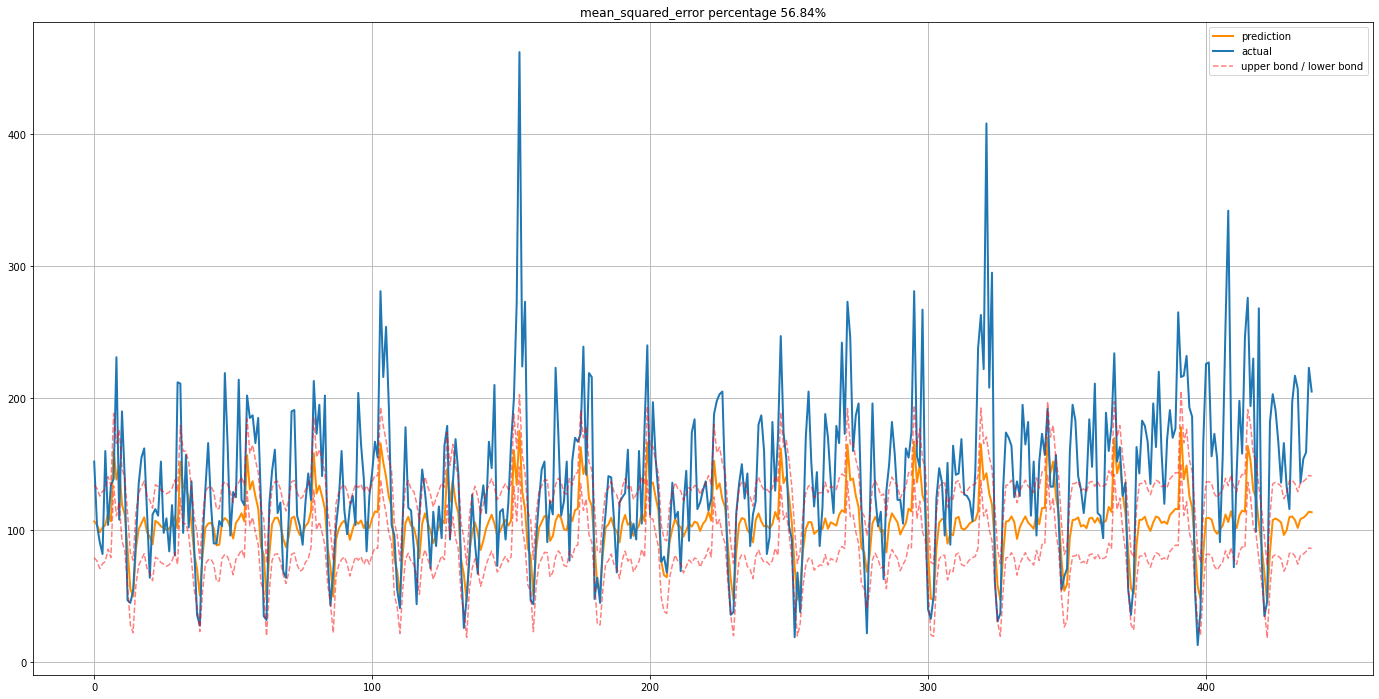

In [34]:
analysis_model('CatBoost', catBoost_grid, X_test, y_test, X_train, y_train, catBoost_grid.best_params_)

#### Dummy Model

In [35]:
%%time

dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)

Wall time: 1.18 ms


DummyRegressor()

model name: Dummy Regressor
Parameters: None
RMSE for training set: 38.71108850997706
RMSE for test set: 84.69779992674266


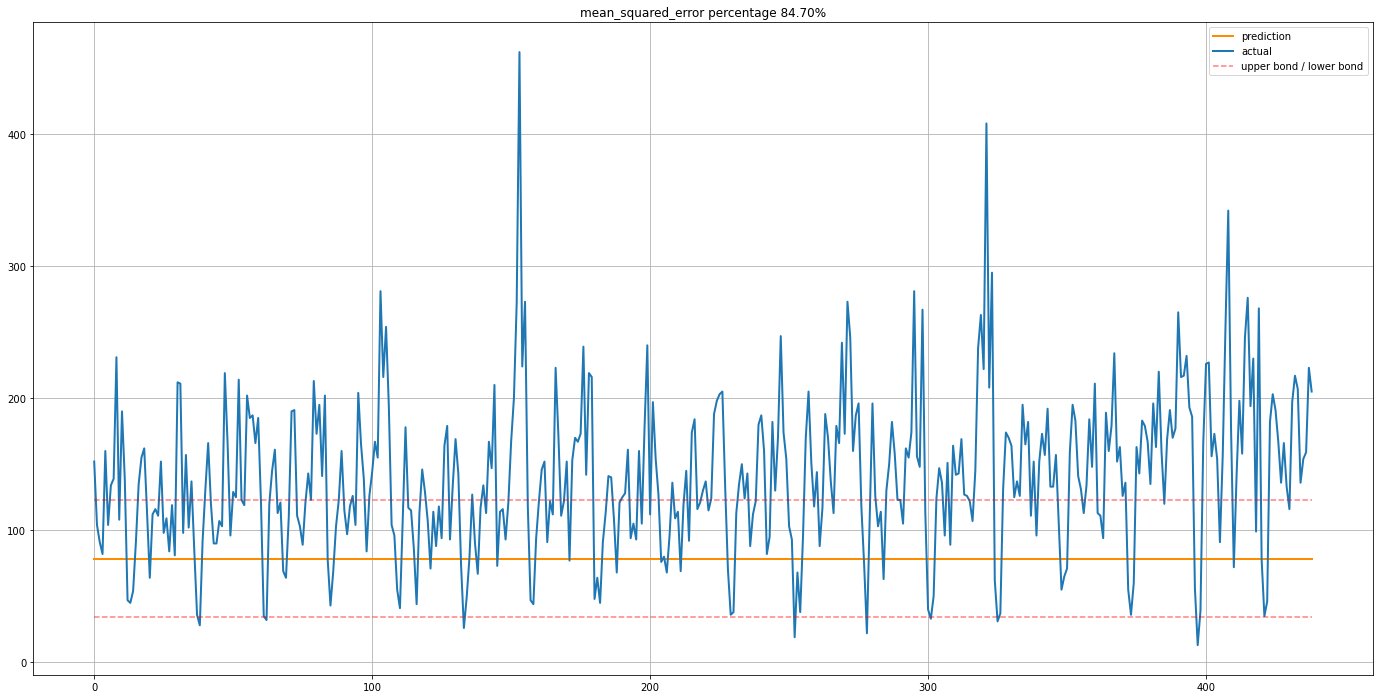

In [36]:
analysis_model('Dummy Regressor', dummy_model, X_test, y_test, X_train, y_train)

In [37]:
results = pd.DataFrame.from_dict(data = table_results, orient='index').reset_index(drop=True)
results

,model,rmse test,rmse train
0,Linear Regression,50.646368,30.378687
1,Random Forest Regressor,49.279860,11.134456
2,XGBRegressor,42.407508,8.999163
3,LightGBM,42.939007,5.724592
4,CatBoost,56.841374,24.647553
5,Dummy Regressor,84.697800,38.711089


Text(0.5, 1.0, 'RMSE for different models')

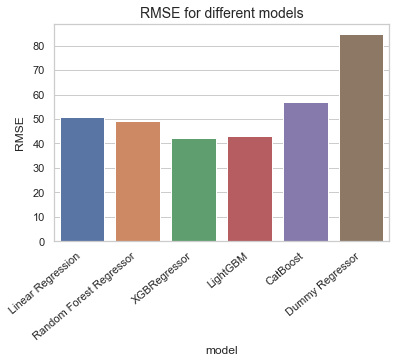

In [38]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="model", y="rmse test", data = results)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right');
ax.set_ylabel(('RMSE'), fontsize=12, labelpad=7.5)
ax.set_title(('RMSE for different models'), fontsize=14)

### Considerations


The following features were added to be able to study the time series:

    Day of the week
    Hour
    Lagging values
    Moving average.

XGBRegressor showed the best result on the training set with best RMSE (42.4)



### Final Conclusion

 - It was able to conclude that the trend of taxis is increasing.
 - Orders have a higher demand at night and during the week
 - Based in the results (RMSE (42.4)) XGBRegressor	is the best model from the 5 models studied 